# Adjacent layer backpropagation

Here I'm going to:

- take my multitask model from before
- extract adjacent layer gradients using the mapping method with the network scaffold I suppose with _normalised_ gradients from the following layer (so as to keep the edge-weights layer-wise, not output-wise - the idea is to create some kind of flow)
- extract the intralayer gradients by dotting between gradients for each of the following layer's components. This is a bit difficult to explain but hopefully in code it'll make more sense.
- create the edge weights accordingly

In [1]:
import torch
from torch import nn
from torch.optim import Adam
from matplotlib import pyplot as plt
from matplotlib import cm
import pandas as pd
from tqdm.notebook import tqdm
import numpy as np

from physics_mi.utils import set_all_seeds

In [2]:
seed = np.random.randint(1, 2**32 - 1)
# seed = 1322468781  # this one is very interesting
set_all_seeds(seed)
print(seed)

4090191675


## Model

Keeping this extremely simple

In [3]:
class LinearLayer(nn.Module):
    def __init__(self, in_feats, out_feats, use_act=True, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.linear = nn.Linear(in_feats, out_feats)
        if use_act:
            self.act = nn.ReLU()
        self.use_act = use_act

    def forward(self, x):
        x = self.linear(x)
        if self.use_act:
            x = self.act(x)
        return x


class Net(nn.Module):
    def __init__(
        self, input_dim=4, hidden_dim=16, output_dim=2, *args, **kwargs
    ) -> None:
        super().__init__(*args, **kwargs)
        self.layers = nn.Sequential(
            LinearLayer(input_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, hidden_dim, use_act=True),
            LinearLayer(hidden_dim, output_dim, use_act=False),
        )

    def forward(self, x):
        return self.layers(x)

## Data

In [4]:
import torch

# Number of samples
n_samples = 10000

# Epsilon value
eps = 0.5


# Generate Y values
def generate_Y(n_samples):
    return torch.rand(n_samples)


# Generate X values based on Y
def generate_X(Y, eps):
    X = torch.empty(len(Y), 2)
    X[:, 0] = Y / (torch.rand(len(Y)) * (1 - eps) + eps)
    X[:, 1] = Y / X[:, 0]

    # Randomly swap x1 and x2
    mask = torch.rand(len(Y)) < 0.5
    swap_vals = X[:, 0][mask]
    X[:, 0][mask] = X[:, 1][mask]
    X[:, 1][mask] = swap_vals

    return X


# Initial generation
Y1 = generate_Y(n_samples)
X1 = generate_X(Y1, eps)

# Ensure they are statistically independent by generating new Y and X values
Y2 = generate_Y(n_samples)
X2 = generate_X(Y2, eps)

# Stack X1 and X2 to get the desired shape
X = torch.cat((X1, X2), dim=1)

# Stack Y1 and Y2 for the desired shape
Y = torch.stack((Y1, Y2), dim=1)

# Validate the relationship
assert torch.allclose(X[:, 0] * X[:, 1], Y[:, 0])
assert torch.allclose(X[:, 2] * X[:, 3], Y[:, 1])

# Print the shapes
print(X.shape, Y.shape)

torch.Size([10000, 4]) torch.Size([10000, 2])


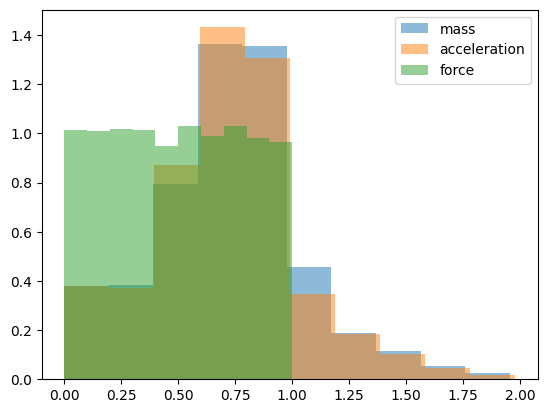

In [5]:
fig, ax = plt.subplots()

ax.hist(X[:, 0], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 1], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 0], alpha=0.5, density=True, label="force")
ax.legend()

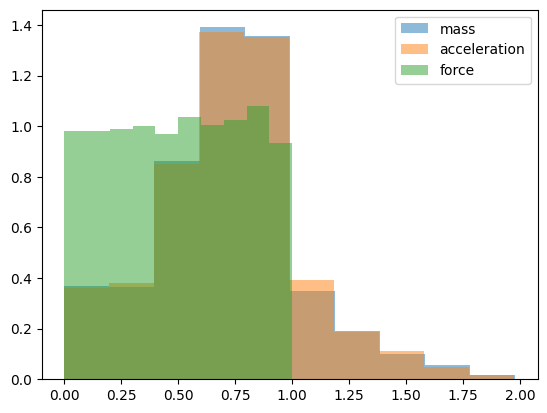

In [6]:
fig, ax = plt.subplots()

ax.hist(X[:, 2], alpha=0.5, density=True, label="mass")
ax.hist(X[:, 3], alpha=0.5, density=True, label="acceleration")
ax.hist(Y[:, 1], alpha=0.5, density=True, label="force")
ax.legend()

Ok, both now look identically distributed.

In [7]:
s_inds = np.random.permutation(range(X.shape[0]))  # shuffled indices

X_train = X[s_inds[:8000]]
Y_train = Y[s_inds[:8000]]
X_valid = X[s_inds[8000:]]
Y_valid = Y[s_inds[8000:]]

X_train.shape, Y_train.shape, X_valid.shape, Y_valid.shape

(torch.Size([8000, 4]),
 torch.Size([8000, 2]),
 torch.Size([2000, 4]),
 torch.Size([2000, 2]))

## Training

I'll just do full gradient descent to keep things simple.

In [8]:
N = 1000  # number of epochs
hidden_dim = 16  # number of hidden units

model = Net(input_dim=4, hidden_dim=hidden_dim, output_dim=2)
loss_func = nn.MSELoss()
optimiser = Adam(model.parameters(), lr=1e-2)
log = []

for i in tqdm(range(N)):
    log_sample = {}

    # Training update
    model.train()
    model.zero_grad()
    Y_hat = model(X_train)
    loss = loss_func(Y_hat, Y_train)
    log_sample["train_loss"] = float(loss.detach())
    loss.backward()
    optimiser.step()

    # Validation set
    model.eval()
    Y_hat = model(X_valid)
    loss = loss_func(Y_hat, Y_valid)
    log_sample["valid_loss"] = float(loss.detach())

    log.append(log_sample)

df = pd.DataFrame(log)

  0%|          | 0/1000 [00:00<?, ?it/s]

## Results

In [9]:
from physics_mi.eval import *


# need to avoid flattening here because we have multiple outputs
def get_preds(model, X_valid, Y_valid):
    model.eval()

    with torch.inference_mode():
        out = model(X_valid)

    y_preds = out.numpy()
    y_targs = Y_valid.numpy()

    return y_preds, y_targs

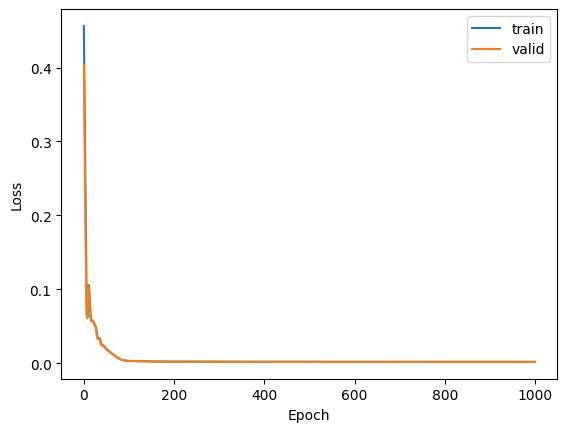

In [10]:
plot_loss(df["train_loss"], df["valid_loss"])

In [11]:
y_preds, y_targs = get_preds(model, X_valid, Y_valid)
y_preds.shape, y_targs.shape

((2000, 2), (2000, 2))

In [12]:
get_valid_loss(model, loss_func, X_valid, Y_valid)

tensor(0.0017)

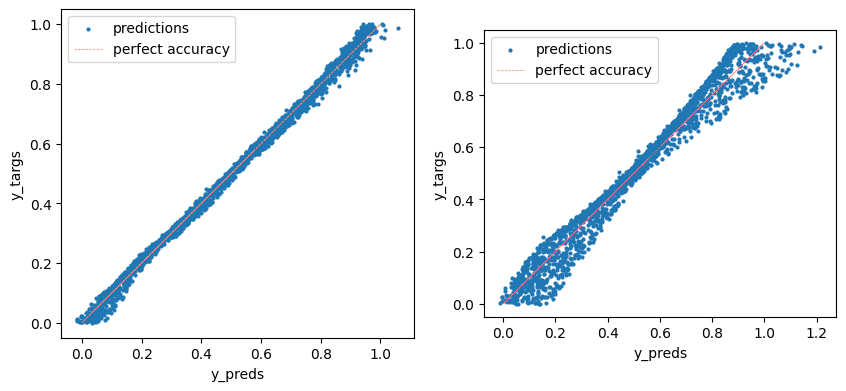

In [13]:
fig, axes = plt.subplots(1, 2, figsize=(10, 10))

plot_results(y_preds[:, 0], y_targs[:, 0], ax=axes[0])
plot_results(y_preds[:, 1], y_targs[:, 1], ax=axes[1])

Both tasks seem to be doing well in parallel 👍

## Introspection

In [14]:
from physics_mi.analysis import capture_intermediate_outputs

In [15]:
def get_inputs(N=100, vary_task="A"):
    pairs = np.concatenate(
        np.stack(np.meshgrid(np.linspace(0, 1, N), np.linspace(0, 1, N))).T
    )
    pairs = torch.tensor(pairs, dtype=torch.float32)
    if vary_task == "A":
        inputs = torch.cat((pairs, torch.full((len(pairs), 2), 0.5)), dim=1)
    if vary_task == "B":
        inputs = torch.cat((torch.full((len(pairs), 2), 0.5), pairs), dim=1)
    return inputs

In [16]:
task_inputs = torch.cat(
    (get_inputs(100, vary_task="A"), get_inputs(100, vary_task="B"))
)
task_inputs.shape

torch.Size([20000, 4])

In [17]:
valid_ios = capture_intermediate_outputs(model, X_valid)
valid_ios["input"] = X_valid
task_ios = capture_intermediate_outputs(model, task_inputs)
task_ios["input"] = task_inputs

In [18]:
valid_ios["layers.0.act"].shape, valid_ios["layers.1.act"].shape

(torch.Size([2000, 16]), torch.Size([2000, 16]))

In [19]:
model

Net(
  (layers): Sequential(
    (0): LinearLayer(
      (linear): Linear(in_features=4, out_features=16, bias=True)
      (act): ReLU()
    )
    (1): LinearLayer(
      (linear): Linear(in_features=16, out_features=16, bias=True)
      (act): ReLU()
    )
    (2): LinearLayer(
      (linear): Linear(in_features=16, out_features=2, bias=True)
    )
  )
)

In [20]:
class ScaffoldNet(Net):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.requires_grad_(False)

    def forward(self, lidx, linputs):
        sub_net = self.layers[lidx : lidx + 1]
        out = sub_net(linputs)
        return out


scaffold_model = ScaffoldNet()
scaffold_model.load_state_dict(model.state_dict())

<All keys matched successfully>

In [21]:
import networkx as nx
from collections import defaultdict


# required because torch.unique does not preserve order of appearance and doesn't provide indices (https://github.com/pytorch/pytorch/issues/36748)
def unique(x, dim=0):
    unique, inverse, counts = torch.unique(
        x, dim=dim, sorted=True, return_inverse=True, return_counts=True
    )
    inv_sorted = inverse.argsort(stable=True)
    tot_counts = torch.cat((counts.new_zeros(1), counts.cumsum(dim=0)))[:-1]
    index = inv_sorted[tot_counts]
    return unique, inverse, counts, index


G = nx.DiGraph()

node_idx = 0

# have to treat the output layer differently because it is in privileged basis
output_lk = "layers.2.linear.bias"
output = valid_ios[output_lk]
num_classes = output.shape[1]
indices = torch.arange(0, num_classes)
one_hot = torch.eye(num_classes)[indices]
for cidx, out_comp in enumerate(output.transpose(1, 0)):
    node = (node_idx, {"layer": output_lk, "comp": one_hot[cidx], "norm": 1.0})
    G.add_node(node[0], **node[1])
    node_idx += 1

layer_keys = ["input", "layers.0.act", "layers.1.act", "layers.2.linear.bias"]
reversed_layer_keys = layer_keys[::-1]
reverse_indices = list(range(len(layer_keys) - 1))[::-1]

for lidx, lk_input, lk_output in zip(
    reverse_indices,
    reversed_layer_keys[1:],
    reversed_layer_keys[:-1],
):  # iterate over pairs of layers at a time
    print(lidx, lk_input, lk_output)
    linputs = valid_ios[lk_input].clone().requires_grad_(True)
    out = scaffold_model(lidx, linputs)
    output_layer_nodes = [
        node for node, attr in G.nodes(data=True) if attr.get("layer") == lk_output
    ]
    out_comps = torch.stack(
        [attrs["comp"] for _, attrs in G.subgraph(output_layer_nodes).nodes(data=True)]
    )
    out_comps = out_comps / torch.norm(
        out_comps, dim=1, keepdim=True
    )  # normalise because we want to examine the upstream weights, not downstream
    out = torch.einsum(
        "ij,kj->ik", out, out_comps
    )  # mapping onto the output components

    grads = defaultdict(dict)

    # through each node/component of the output layer
    for cidx, comp_act in enumerate(out.transpose(1, 0)):
        loss = comp_act.mean()
        loss.backward(retain_graph=True)
        input_grads = linputs.grad.clone().detach()
        grads[lk_input][cidx] = input_grads
        uq_input_grads, _, _, index = unique(input_grads, dim=0)
        uq_input_grads = uq_input_grads[
            torch.argsort(index)
        ]  # now in order of appearance so they can be matched with grads from other output nodes
        uq_input_grad_norms = torch.norm(uq_input_grads, dim=1)
        for grad, norm in zip(uq_input_grads, uq_input_grad_norms):
            norm = float(norm)
            node = (node_idx, {"layer": lk_input, "comp": grad, "norm": norm})
            G.add_node(node[0], **node[1])
            G.add_edge(node_idx, output_layer_nodes[cidx], weight=norm)
            node_idx += 1
        linputs.grad.zero_()

2 layers.1.act layers.2.linear.bias
1 layers.0.act layers.1.act
0 input layers.0.act


Now I need to create inter-component edges, i.e. how much do the gradients produced from one component affect another component. I _think_ I can do this by dotting the gradients with the other component's gradients and doing a sum aggregation or something but I need to be careful to make sure that the meaning of this weights is equivalent to the existing weights otherwise the graph will have inconsistencies.

I'm expecting to see:
- intra task connectivity - components for the same task share some inbound gradient directions
- very little inter task connectivity - components for different tasks do not share inbound gradient directions

**TODO:** modify the below to only do dot product between relevant gradients (i.e. the gradient in the same position for each output node e.g. 0th->0th, 1st->1st etc.)

In [22]:
for lidx, (lk_input, lk_output) in enumerate(zip(layer_keys[:-1], layer_keys[1:])):
    input_nodes = [
        node for node, attr in G.nodes(data=True) if attr.get("layer") == lk_input
    ]
    output_nodes = [
        node for node, attr in G.nodes(data=True) if attr.get("layer") == lk_output
    ]
    input_grads = [attr["comp"] for _, attr in G.subgraph(input_nodes).nodes(data=True)]
    input_grads = torch.stack(input_grads)
    input_nodes = torch.as_tensor(input_nodes)
    for output_node in output_nodes:
        relevant_nodes = torch.as_tensor(
            [source for source, _, _ in G.in_edges(output_node, data=True)]
        )  # we've already got weights for these
        relevant_mask = torch.isin(input_nodes, relevant_nodes)
        weights = torch.einsum(
            "ij,kj->i", input_grads[~relevant_mask], input_grads[relevant_mask]
        )
        source_nodes = (input_nodes[~relevant_mask]).tolist()
        target_nodes = [output_node] * len(source_nodes)
        for source, target, weight in zip(source_nodes, target_nodes, weights):
            G.add_edge(source, target, weight=float(weight))

In [23]:
for lidx, lk in enumerate(layer_keys):
    layer_nodes = [node for node, attr in G.nodes(data=True) if attr.get("layer") == lk]
    layer_nodes = sorted(layer_nodes)
    spacing = 1.0 / len(layer_nodes)
    Y = np.linspace(-0.5, +0.5, len(layer_nodes))
    for node, y in zip(layer_nodes, Y):
        G.nodes[node]["pos"] = (lidx, y)

In [24]:
max_width = 2.0

pos = nx.get_node_attributes(G, "pos")
edge_weights = nx.get_edge_attributes(G, "weight")
scaled_weights = {
    (u, v): weight / max(edge_weights.values()) * max_width
    for (u, v), weight in edge_weights.items()
}

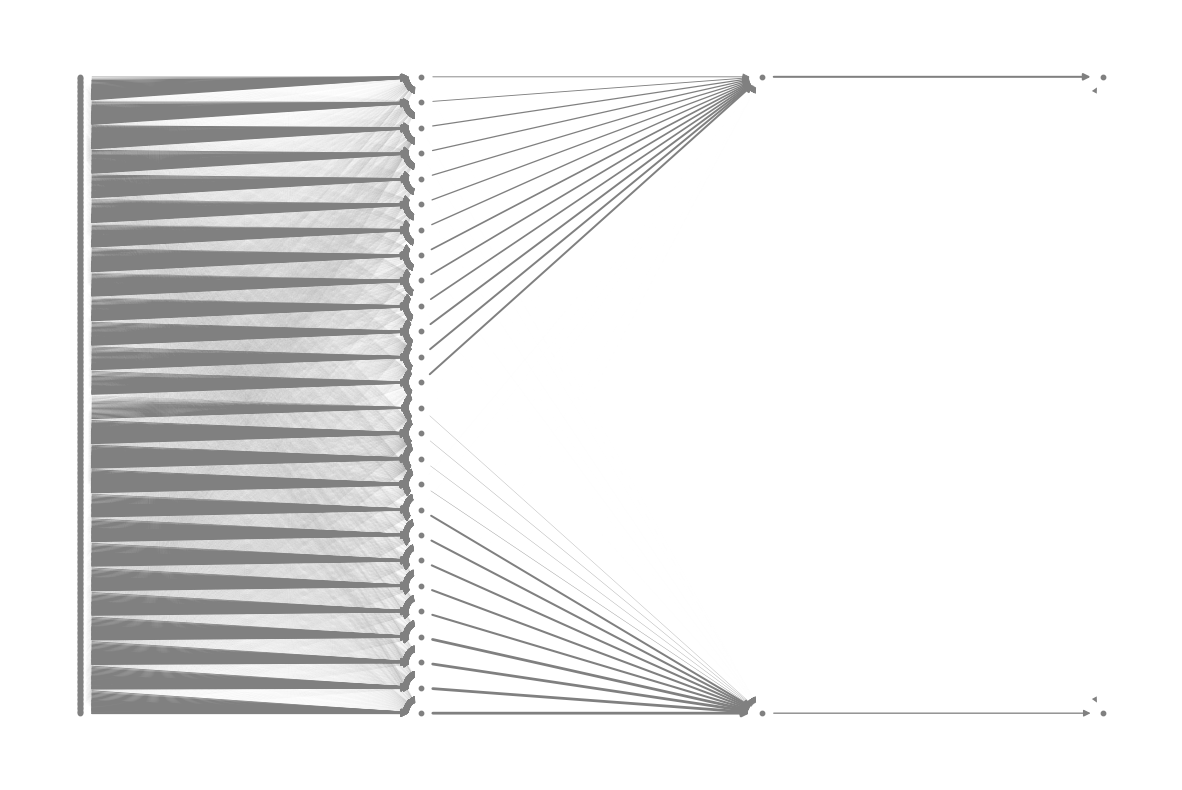

In [25]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 10))

# Draw nodes
nx.draw_networkx_nodes(G, pos, node_color="gray", node_size=10)

# Draw edges with weights influencing the line thickness
for (u, v), weight in scaled_weights.items():
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=weight, edge_color="gray")

# Draw node labels
# nx.draw_networkx_labels(G, pos, font_size=8)

# Optionally, draw edge labels (weights)
# nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_weights)

# plt.title("Graph with Weight-Based Edge Thickness")
_ = plt.axis("off")  # Turn off the axis